# Assignment 3 Solution 

## Xiqiao Xie

## 1002905118




In this assignment, we will implement and investigate the Variational Autoencoder on binarized MNIST digits, as introduced by the paper Auto-Encoding Variational Bayes by Kingma and Welling (2013). Before starting, we recommend reading this paper.

### Data.
Each datapoint in the MNIST dataset is a 28x28 grayscale image (i.e. pixels are values between 0 and 1) of a handwritten digit in $\{0 \dots 9\}$, and a label indicating which number.
MNIST is the 'fruit fly' of machine learning -- a simple standard problem useful for comparing the properties of different algorithms.

Use the first 10000 samples for training, and the second 10000 for testing.
Hint: Also build a dataset of only 100 training samples to use when debugging, to make loading and training faster.

### Tools
As before, you can (and should) use automatic differentiation provided by your package of choice.
Whereas in previous assignments you implemented neural network layers and stochastic gradient descent manually, in this assignment feel free to use those provided by a machine learning framework.
In Julia, these will be provided by $\texttt{Flux.jl}$.
You can also freely copy and adapt the Python autograd starter code provided.  
If you do, you should probably remove batch normalization.

However, you $\textbf{may not use any probabilistic modelling elements}$ from these frameworks.
In particular, sampling from and evaluating densities under distributions must be written by you or provided by the starter code.

## Model Definition 

### Prior. 
The prior over each digit's latent representation is a multivariate standard normal distribution.
For all questions, we'll set the dimension of the latent space $D_z$ to 2.
A larger latent dimension would provide a more powerful model, but for this assignment we'll use a two-dimensional latent space to make visualization and debugging easier..


### Likelihood 
Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.




For your convenience we have provided the following functions:


In [4]:
# log-pdf of x under Factorized or Diagonal Gaussian N(x|μ,σI)
# log-likelihood
function factorized_gaussian_log_density(mu, logsig,xs)
  """
  mu and logsig either same size as x in batch or same as whole batch
  returns a 1 x batchsize array of likelihoods
  """
  σ = exp.(logsig)
  return sum((-1/2)*log.(2π*σ.^2) .+ -1/2 * ((xs .- mu).^2)./(σ.^2),dims=1)
    end;

In [5]:
# log-pdf of x under Bernoulli
# log-likelihood of bernoulli
function bernoulli_log_density(logit_means,x)
  """Numerically stable log_likelihood under bernoulli by accepting μ/(1-μ)"""
  b = x .* 2 .- 1 # {0,1} -> {-1,1}
  return - log1pexp.(-b .* logit_means)
    end;

In [6]:
# sample from Diagonal Gaussian x~N(μ,σI) (hint: use reparameterization trick here)
sample_diag_gaussian(μ,logσ) = (ϵ = randn(size(μ)); μ .+ exp.(logσ).*ϵ);
# sample from Bernoulli (this can just be supplied by library)
sample_bernoulli(θ) = rand.(Bernoulli.(θ));

In [7]:
# Load MNIST data, binarise it, split into train and test sets (10000 each) and partition train into mini-batches of M=100.
# You may use the utilities from A2, or dataloaders provided by a framework
function load_binarized_mnist(train_size=1000, test_size=1000)
  train_x, train_label = MNIST.traindata(1:train_size);
  test_x, test_label = MNIST.testdata(1:test_size);
  @info "Loaded MNIST digits with dimensionality $(size(train_x))"
  train_x = reshape(train_x, 28*28,:)
  test_x = reshape(test_x, 28*28,:)
  @info "Reshaped MNIST digits to vectors, dimensionality $(size(train_x))"
  train_x = train_x .> 0.5; #binarize
  test_x = test_x .> 0.5; #binarize
  @info "Binarized the pixels"
  return (train_x, train_label), (test_x, test_label)
    end;

In [8]:
function batch_data((x,label)::Tuple, batch_size=100)
  """
  Shuffle both data and image and put into batches
  """
  N = size(x)[end] # number of examples in set
  rand_idx = shuffle(1:N) # randomly shuffle batch elements
  batch_idx = Iterators.partition(rand_idx,batch_size) # split into batches
  batch_x = [x[:,i] for i in batch_idx]
  batch_label = [label[i] for i in batch_idx]
  return zip(batch_x, batch_label)
end;
# if you only want to batch xs
batch_x(x::AbstractArray, batch_size=100) = first.(batch_data((x,zeros(size(x)[end])),batch_size));

In [9]:
## Load the Data
train_data, test_data = load_binarized_mnist();
train_x, train_label = train_data;
test_x, test_label = test_data;

UndefVarError: UndefVarError: MNIST not defined

In [12]:
Dz, Dh = 2, 500
Ddata = 28^2

784

## 1. Implementing the Model

**(a).** Implement a function `log_prior` that computes the log of the prior over a digit's representation $\log p(z)$.

In [13]:
## Model Distributions
# 1.(a)
μ_z_default = 0;
σ_z_default = 1;
log_prior(z) = factorized_gaussian_log_density(μ_z_default, log.(σ_z_default), z)


log_prior (generic function with 1 method)

**(b).** Implement a function `decoder` that, given a latent representation $z$ and a set of neural network parameters $\theta$ (again, implicitly in Flux), produces a 784-dimensional mean vector of a product of Bernoulli distributions, one for each pixel in a $28 \times 28$ image.
	Make the decoder architecture a multi-layer perceptron (i.e. a fully-connected neural network) with a single hidden layer with $500$ hidden units, and a `tanh` nonlinearity.
  Its input will be a batch two-dimensional latent vectors ($z$s in $D_z \times B$) and its output will be a 784-dimensional vector representing the logits of the Bernoulli means for each dimension $D_\text{data}\times B$.
	For numerical stability, instead of outputting the mean $\mu \in [0,1]$, you should output $\log \left( \frac{\mu}{1 - \mu} \right) \in \mathbb{R}$ called ``logit".

In [14]:
# 1.(b)
decoder = Chain(Dense(Dz, Dh, tanh), Dense(Dh, Ddata)) #2*B -> 784*B
# decoder(z) = mean(n_net(z), dims = 2)

Chain(Dense(2, 500, tanh), Dense(500, 784))

**(c).** Implement a function `log_likelihood` that, given a latent representation $z$ and a binarized digit $x$, computes the log-likelihood $\log p(x|z)$.

In [47]:
function log_likelihood(x,z)
  """ Compute log likelihood log_p(x|z)"""
  θ = decoder(z)  #parameters decoded from latent z, logit_μ
  return  sum(bernoulli_log_density(θ, x), dims = 1)
    end; 

**(d).** Implement a function `joint_log_density` which combines the log-prior and log-likelihood of the observations to give $\log p(z, x)$ for a single image.

In [48]:
# 1.(d)
joint_log_density(x,z)  = log_prior(z) .+ log_likelihood(x,z);

## 2. Amortized Approximate Inference and Training 

**(a).** Write a function `encoder` that, given an image $x$ (or batch of images) and recognition parameters $\phi$, evaluates an MLP to outputs the mean and log-standard deviation of a factorized Gaussian of dimension $D_z = 2$.
	Make the encoder architecture a multi-layer perceptron (i.e. a fully-connected neural network) with a single hidden layer with $500$ hidden units, and a `tanh` nonlinearity.
	This function must be able to be evaluated in parallel on a batch of images, using the same parameters $\phi$ for each image.

In [49]:
## Amortized Inference
function unpack_gaussian_params(θ)
  μ, logσ = θ[1:2,:], θ[3:end,:]
  return  μ, logσ
    end;

encoder= Chain(Dense(Ddata , Dh, tanh), Dense(Dh, 4), unpack_gaussian_params);
# output the parameters of q(z|x), if want z, need to use sample functions

**(b).** Write a function `log_q` that given the parameters of the variational distribution, evaluates the likelihood of $z$.

In [171]:
log_q(q_μ, q_logσ, z) = factorized_gaussian_log_density(q_μ, q_logσ, z)

log_q (generic function with 1 method)

**(c).** Implement a function `elbo` which computes an unbiased estimate of the mean variational evidence lower bound on a batch of images. Use the output of `encoder` to give the parameters for $q_{\phi}(z|data)$. 

In [80]:
function elbo(x)
  q_μ, q_logσ = encoder(x) # variational parameters from data
  z = sample_diag_gaussian(q_μ, q_logσ) #sample from variational distribution
  joint_ll = joint_log_density(x, z) #joint likelihood of z and x under model, log_p(z, x)
  log_q_z = factorized_gaussian_log_density(q_μ, q_logσ, z) #likelihood of z under variational distribution, log_q(z|x)
  elbo_estimate = mean(joint_ll .- log_q_z)#Scalar value, mean variational evidence lower bound over batch
  return elbo_estimate
    end;



**(d).** Write a loss function called `loss` that returns the negative elbo estimate over a batch of data.

In [ ]:
function loss(x)  # negative elbo estimate over a batch of data
  return -elbo(x) #scalar value for the variational loss over elements in the batch
    end;

**(e).** Write a function that initializes and optimizes the encoder and decoder parameters jointly on the training set. Note that this function should optimize with gradients on the elbo estimate over batches of data, not the entire data set. Train the data for 100 epochs. Report the final elbo on the test set. 

In [51]:
function train_model_params!(loss, encoder, decoder, train_x, test_x; nepochs=10)
  # model params
  ps =  Flux.params(encoder, decoder) #parameters to update with gradient descent
  # ADAM optimizer with default parameters
  opt = ADAM()
  # over batches of the data
  for i in 1:nepochs
    for d in batch_x(train_x)
      gs = Flux.gradient(() -> loss(train_x), ps) # compute gradients with respect to variational loss over batch
      # update the paramters with gradients
      Flux.Optimise.update!(opt, ps, gs)
    end
    if i%10 == 1 # change 1 to higher number to compute and print less frequently
      @info "Test loss at epoch $i: $(loss(batch_x(test_x)[1]))"
    end
  end
  @info "Parameters of encoder and decoder trained!"
end

train_model_params! (generic function with 1 method)

In [52]:
## Train the model
train_model_params!(loss,encoder,decoder,train_x,test_x, nepochs=100)

┌ Info: Test loss at epoch 1: 189.94903462340585
└ @ Main In[51]:14
┌ Info: Test loss at epoch 11: 180.044013728913
└ @ Main In[51]:14
┌ Info: Test loss at epoch 21: 180.4300729097509
└ @ Main In[51]:14
┌ Info: Test loss at epoch 31: 178.41652350608467
└ @ Main In[51]:14
┌ Info: Test loss at epoch 41: 169.18081499565892
└ @ Main In[51]:14
┌ Info: Test loss at epoch 51: 176.79557320087403
└ @ Main In[51]:14
┌ Info: Test loss at epoch 61: 180.75270293688496
└ @ Main In[51]:14
┌ Info: Test loss at epoch 71: 189.29542634315706
└ @ Main In[51]:14
┌ Info: Test loss at epoch 81: 172.88909668749685
└ @ Main In[51]:14
┌ Info: Test loss at epoch 91: 188.9370726361924
└ @ Main In[51]:14
┌ Info: Parameters of encoder and decoder trained!
└ @ Main In[51]:17


In [53]:
# save the trained model!
using BSON:@save
cd(@__DIR__)
@info "Changed directory to $(@__DIR__)"
save_dir = "trained_models"
if !(isdir(save_dir))
  mkdir(save_dir)
  @info "Created save directory $save_dir"
end
@save joinpath(save_dir,"encoder_params.bson") encoder
@save joinpath(save_dir,"decoder_params.bson") decoder
@info "Saved model params in $save_dir"


┌ Info: Changed directory to /Users/paulxie/Documents/STA414/STA414-2020-A3-Pxie024
└ @ Main In[53]:4
┌ Info: Saved model params in trained_models
└ @ Main In[53]:12


## 3. Visualizing Posteriors and Exploring the Model 

In this section we will investigate out model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between digits. 

**(a).** Plot samples from the trained generative model using ancestral sampling.

In [54]:
# Visualization
using Images
using Plots
# make vector of digits into images, works on batches also
mnist_img(x) = ndims(x)==2 ? Gray.(reshape(x,28,28,:)) : Gray.(reshape(x,28,28))

mnist_img (generic function with 1 method)

In [244]:
# sample z from prior distribution 
μ_z = randn(Dz, 10);
log_σ_z = randn(Dz, 10);


sample_z = sample_diag_gaussian(μ_z, log_σ_z)
logit_mu_x = decoder(sample_z)
μ_x = exp.(logit_mu_x) ./ (1 .+ exp.(logit_mu_x))
sample_x = sample_bernoulli(μ_x);


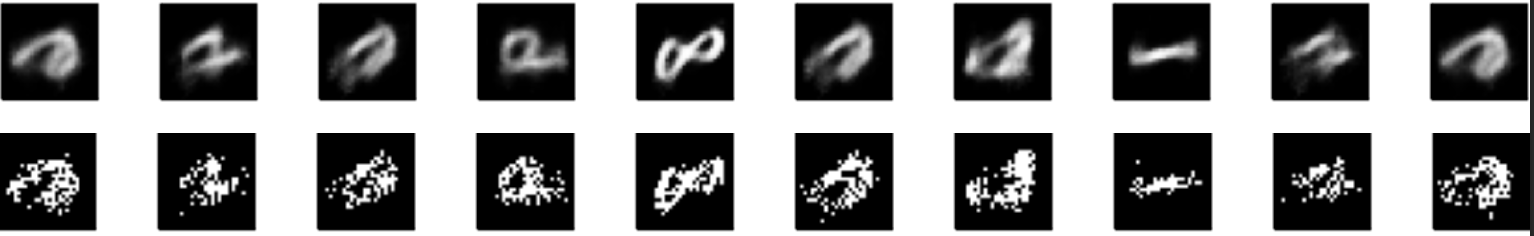

**(b).** One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we will produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set. 

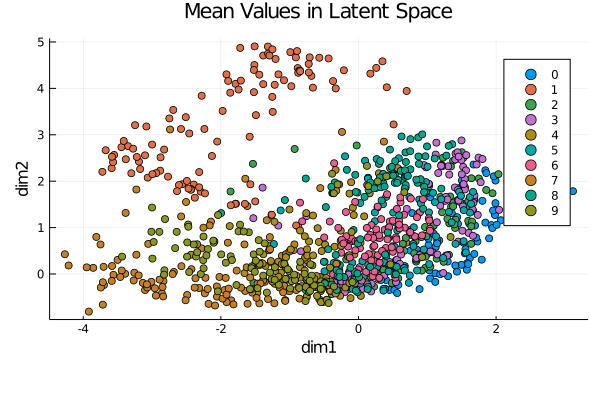

In [25]:
# encode each image in the training set
params_q = encoder(train_x) #parameters for q(z|x)

# take 2D mean vector
mean_1 = params_q[1][1 ,:]
mean_2 = params_q[1][2 ,:]
scatter(mean_1, mean_2, xlabel= "dim1", ylabel = "dim2",  
        title = "Mean Values in Latent Space", group = train_label)

**(c).** Another way to examine a latent variable model with continuous latent variables is to interpolate between the latent representation of twp points.

Here we will encode 3 pairs of datapoints with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will polt the generative distributions along the linear interpolation. 

In [27]:
# linear interpolation 
linear_interp(za, zb, α) = α .* za .+ (1 .- α) .* zb ;


In [70]:
# sample 3 pairs of images, with different class labels
inter_label = zeros(3)
inter_x = zeros(28^2 , 3)
for i in inter_label
    if count(x->x==i , inter_label) != 1
        rand_index = rand(1:1000, 3)
        inter_x = train_data[1][: , rand_index]
        inter_label = train_data[2][rand_index]
    end
end

# encode the data and take mean vectors 
means , logstds = encoder(inter_x)

α_values = 0:1/9:1  #actual values for α
x_mean_1 = []
x_mean_2 = []
x_mean_3 = []

z1 = sample_diag_gaussian(means[:,1], logstds[:,1]);
z2 = sample_diag_gaussian(means[:,2], logstds[:,2]);
z3 = sample_diag_gaussian(means[:,3], logstds[:,3]);
for α in α_values
    z_1_2 = linear_interp(z1, z2, α);  #linear interpolation zα between μ1 and μ2
    z_1_3 = linear_interp(z1, z3, α);
    z_2_3 = linear_interp(z2, z3, α);

    logit_ber_mean_1 = decoder(z_1_2);
    ber_mean_1 = exp.(logit_ber_mean_1) ./ (1 .+ exp.(logit_ber_mean_1));
    append!(x_mean_1, [ber_mean_1])

    logit_ber_mean_2 = decoder(z_1_3);
    ber_mean_2 = exp.(logit_ber_mean_2) ./ (1 .+ exp.(logit_ber_mean_2));
    append!(x_mean_2, [ber_mean_2])

    logit_ber_mean_3 = decoder(z_2_3);
    ber_mean_3 = exp.(logit_ber_mean_3) ./ (1 .+ exp.(logit_ber_mean_3));
    append!(x_mean_3, [ber_mean_3])
end

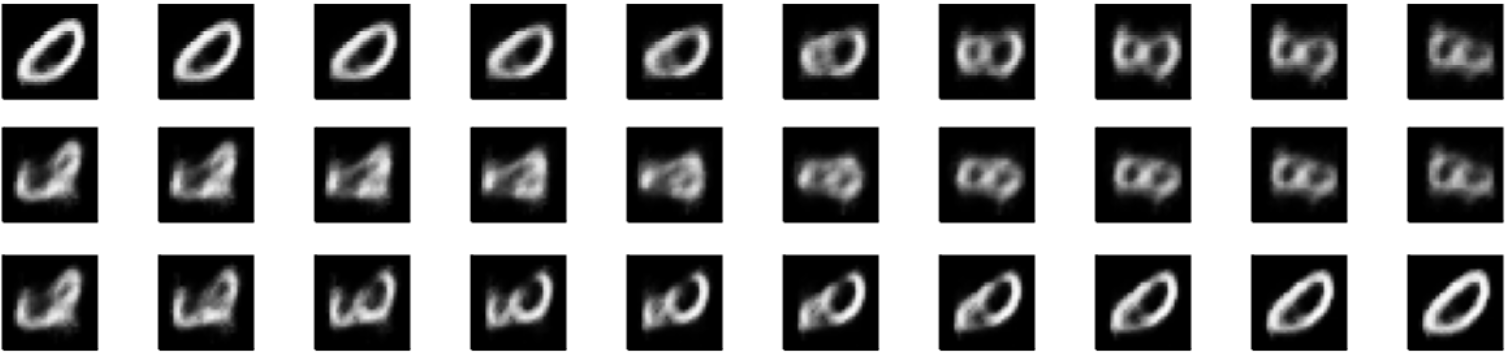


## 4. Predicting the Bottom of Images given the Top 

Now we'll use the trained generative model to perform inference for $p(z|$top half of image x$)$. Unfortunately, we cannot re-use our recognition network, since it can only input entire images. However, we can still do approxomate inference without the encoder. 

 To illustrate this, we'll approximately infer the distribution over the pixels in the bottom half an image conditioned on the top half of the image:
 
   $p($bottom half of imag x | top half of image x$) = \int p($bottom half of imagex |$z) p(z |$top half of image x$)dz$

To approximate the posterior $p(z|$top half of image x$)$, we'll use stochastic variational inference.

**(a).** Write a function that computes $p(z,$ top half of image x)

In [103]:
# a function returns only the top half of a 28^2 array
top_half(x) = x[1:392, :]


function log_likelihood_top(x, z)  #log_likeihood for p(top half of x|z), x a 784*B array
    x_top = top_half(x)
    θ = decoder(z)[1:392]
    return sum(bernoulli_log_density(θ, x_top), dims = 1)
    end;

joint_log_density_top(x, z) = log_prior(z) .+ log_likelihood_top(x, z)

joint_log_density_top (generic function with 1 method)

**(b).** Now, to approximate $p(z|$top half of image x) in a scalable way, we'll use stochastic variational inference. For a digit of your choosing from the training set (choose one that is modelled well, i.e. the resulting plot looks reasonable).

In [168]:
ϕ_init = rand(2), rand(2)  # initializing variational parameters

function elbo_top(x, K, params)  #x is a 784*B array, K is number of samples.
    μ = params[1]
    logstd = params[2]
    measurement  = 0.0
    for i in 1:K
        z = sample_diag_gaussian(μ, logstd)
        measure = log_likelihood_top(x, z) .+ log_prior(z) .- factorized_gaussian_log_density(μ, logstd, z)
        measurement = measurement + mean(measure)
    end
    return measurement / K
    end;

loss_top(x, K, params) = -elbo_top(x, K, params);



In [169]:
# training the parameters
function optimize_params_top(init_params, train_data, K; num_itrs = 200, lr = 1e-2)
    params_cur = init_params
    for i in 1:num_itrs
        grad_params = Flux.gradient(params -> loss_top(train_data, K, params), params_cur)
        params_cur = params_cur .- lr .* grad_params[1]
        if i % 10 == 0
            @info "Test loss at epoch $i: $(loss_top(train_data, K, params_cur))"
        end
    end
    @info "Final ELBO is $(elbo_top(train_data, K, params_cur))"
    return params_cur
    end;

In [170]:
train_params = optimize_params_top(ϕ_init, train_x, 300)

┌ Info: Test loss at epoch 10: 126.35280101385197
└ @ Main In[169]:8
┌ Info: Test loss at epoch 20: 122.21488951553508
└ @ Main In[169]:8
┌ Info: Test loss at epoch 30: 119.44775716459203
└ @ Main In[169]:8
┌ Info: Test loss at epoch 40: 117.32248760496395
└ @ Main In[169]:8
┌ Info: Test loss at epoch 50: 116.32664745358743
└ @ Main In[169]:8
┌ Info: Test loss at epoch 60: 115.64783138388263
└ @ Main In[169]:8
┌ Info: Test loss at epoch 70: 115.45255121224776
└ @ Main In[169]:8
┌ Info: Test loss at epoch 80: 115.35606575781115
└ @ Main In[169]:8
┌ Info: Test loss at epoch 90: 115.1256111791684
└ @ Main In[169]:8
┌ Info: Test loss at epoch 100: 115.14942376517392
└ @ Main In[169]:8
┌ Info: Test loss at epoch 110: 115.07885184127302
└ @ Main In[169]:8
┌ Info: Test loss at epoch 120: 115.10488903687978
└ @ Main In[169]:8
┌ Info: Test loss at epoch 130: 115.11960695695511
└ @ Main In[169]:8
┌ Info: Test loss at epoch 140: 115.07321484978209
└ @ Main In[169]:8
┌ Info: Test loss at epoch 150

([-0.2889371606226794, -0.6305897851967625], [-1.8939299068361175, -1.9191047435599424])

In [251]:
function skillcontour!(f; colour=nothing)
  n = 200
  x = range(-1.5,stop=3/2,length=n)
  y = range(-1.5,stop=3/2,length=n)
  z_grid = Iterators.product(x,y) # meshgrid for contour
  z_grid = reshape.(collect.(z_grid),:,1) # add single batch dim
  z = f.(z_grid)
  z = getindex.(z,1)'
  max_z = maximum(z)
  levels = [.99, 0.9, 0.8, 0.7,0.6,0.5, 0.4, 0.3, 0.2] .* max_z
  if colour==nothing
  p1 = contour!(x, y, z, fill=false, levels=levels)
  else
  p1 = contour!(x, y, z, fill=false, c=colour,levels=levels,colorbar=false)
  end
  plot!(p1)
end

skillcontour! (generic function with 1 method)

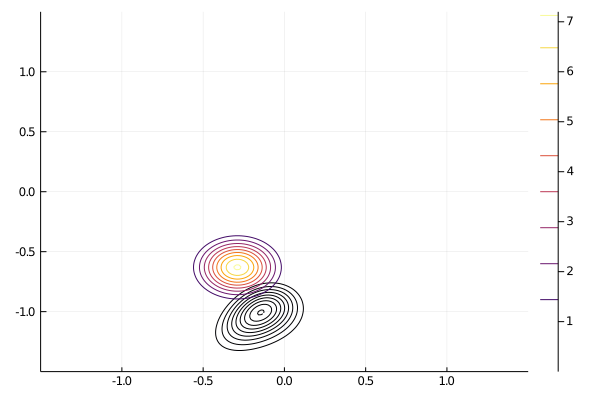

┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/paulxie/.julia/packages/Plots/ZRCUN/src/backends/gr.jl:521


In [255]:
#joint_distribution(zs) = exp.(joint_log_density_top(train_x[:, 1:300], zs));
optimized_posterior(zs) = exp.(factorized_gaussian_log_density(train_params[1], train_params[2], zs))

#plt3 = plot()
#skillcontour!(joint_distribution)
skillcontour!(optimized_posterior)

**Note:** the colored contours are for joint distribution $p(z,\text{top half of image }x)$ and the dark contours are for the optimized approximated posterior $q_{\phi}(z|\text{top half of image }x)$

In [247]:
#z_params = optimize_params_top(ϕ_init, train_x[:, 989], 300);
z_sample = sample_diag_gaussian(z_params[1], z_params[2]);
logit_means = decoder(z_sample);
mean_989 = exp.(logit_means) ./ (1 .+ exp.(logit_means));

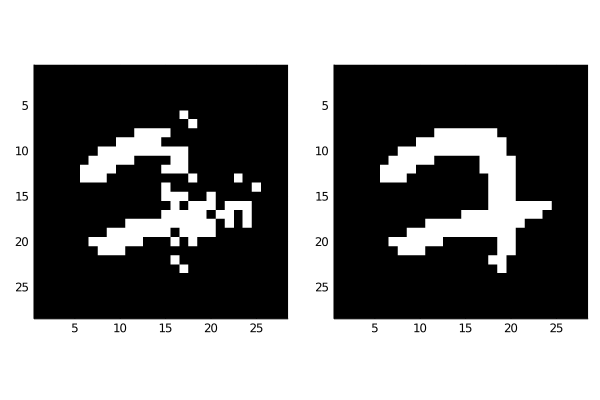

In [435]:
x_approx_bottom = sample_bernoulli(mean_989)[393:784]
x_approx = vcat((top_half(train_x[:, 989])), (x_approx_bottom))[:]
plt4 = plot(layout = (2))
plot!(mnist_img(x_approx), subplot = 1)
plot!(mnist_img(train_x[:,989]), subplot = 2)

**Comment:** somehow the first 784/2 pixels turned out to be the left half of the images, but the idea is the same. 

**(c).** True or false: Questions about teh model and variational inference.
There is no need to explain your work in this section.

* Does the distribution over $p(\text{bottom half of image $x$} | z)$ factorize over the pixels of the bottom half of image $x$?  **Yes, it does**

* Does the distribution over $p(\text{bottom half of image $x$} | \text{top half of image $x$})$ factorize over the pixels of the bottom half of image $x$?  **No, it does not** 

* When jointly optimizing the model parameters $\theta$ and variational parameters $\phi$, if the ELBO increases, has the KL divergence between the approximate posterior $q_\phi(z|x)$ and the true posterior $p_\theta(z|x)$ necessarily gotten smaller?  **Yes** 

* If $p(x) = \mathcal{N}(x | \mu, \sigma^2)$, for some $x \in \mathbb{R}, \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+$, can $p(x) < 0$?  **No, pdf can not be smaller than 0** 

* If $p(x) = \mathcal{N}(x | \mu, \sigma^2)$, for some $x \in \mathbb{R}, \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+$, can $p(x) > 1$? **Yes, if the pdf spans a very short range of x, it could be larger than 1**